## Problem Set 3: Merging and Regular Expressions, Part 1


**Background on the policy context**: here, we"re going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset3_inputdata` (need to unzip): 

- `jobs`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


Here"s a codebook explaining the variables in `jobs.csv`: https://web.archive.org/web/20231129014506/https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-2A_Record_Layout_FY2023_Q4.pdf


In [49]:
## helpful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Reshaping data (13 points total)

Load the following dataset stored in `pset3_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [50]:
## your code here
debar = pd.read_csv("pset3_inputdata/debar.csv")

debar.head()

,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [51]:
## your code here
num_rows = len(debar)
num_employers = debar["Name"].nunique()


print(f"The debar dataset has {num_rows} rows.")
print(f"There are {num_employers} unique employers in the dataset.")
print(f"Considering there is {num_rows - num_employers} more rows than unique employers, some employers must appear multiple times in the dataset.")

The debar dataset has 114 rows.
There are 98 unique employers in the dataset.
Considering there is 16 more rows than unique employers, some employers must appear multiple times in the dataset.


## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [52]:
## your code here
debar["is_repeated"] = debar["Name"].duplicated(keep=False)

mult_debar = debar[debar["is_repeated"] == True].copy()

mult_debar.head()

print(mult_debar.value_counts())
print(f"Shape: {mult_debar.shape}")
print(f"There are {mult_debar["Name"].nunique()} employers that appear multiple times in the dataset with a total of {len(mult_debar)} violations.")


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


Name                                     City, State       Violation                                                                  Duration  Start date  End date    is_repeated
Annabella Land & Cattle                  Annabella, UT     Non Payment                                                                1 year    5/9/2014    5/9/2015    True           1
                                         Annabella, Utah   Non-payment                                                                1 year    5/9/2014    5/8/2015    True           1
Autumn Hill Orchard                      Groton, MA        Failure to respond to audit (no response)                                  2 years   7/6/2014    7/5/2016    True           1
                                                           Impeding the Audit Process – Non- Response                                 2 years   7/6/2014    7/5/2016    True           1
Caddo Creek Ranch, dba Paradise Ranch    Caddo, TX         Failure to respond to

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We"re going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row"s violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [53]:
## your code here

# Create a violation number within each employer group
mult_debar["viol_num"] = mult_debar.groupby(["Name", "City, State"]).cumcount() + 1

# Pivot to wide format with Start date as the values
mult_debar_wide = mult_debar.pivot(
    index=["Name", "City, State"],
    columns="viol_num",
    values="Start date"
).reset_index()

# Rename the columns to match required format
mult_debar_wide.columns = ["Name", "City, State", "start_date_viol1", "start_date_viol2"]

mult_debar_wide.head()
print(f"Shape: {mult_debar_wide.shape}")

,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,NaN
1,Annabella Land & Cattle,"Annabella, Utah",5/9/2014,NaN
2,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
3,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,NaN
4,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, Texas",7/20/2014,NaN


Shape: (20, 4)


## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning -- `debar`

    - Create a column in `debar` called `violnum` that numbers the violations for each employer (so the first violation for an employer is 1, the second is 2, etc)
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == 1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

Save the `debar_clean` as a csv file using `df.to_csv([filename], index=False)`. You will be using it in Problem Set 4.

In [57]:
# Part A: Add is_dup column to mult_debar_wide
mult_debar_wide["is_dup"] = (mult_debar_wide["start_date_viol1"] == mult_debar_wide["start_date_viol2"])
print(mult_debar_wide["is_dup"].value_counts())

# Part B: Filter duplicates from original debar data

# Create violnum column - number violations for each employer
print(f"original debar shape: {debar.shape}")

debar = debar.sort_values(["Name", "City, State"]).copy()
debar["violnum"] = debar.groupby(["Name", "City, State"]).cumcount() + 1

# Get list of duplicate employers (Name + City, State) from the wide frame
dup_employers = mult_debar_wide.loc[mult_debar_wide["is_dup"], ["Name", "City, State"]].drop_duplicates()

# Mark rows in debar that belong to duplicate employers
debar_flagged = debar.merge(dup_employers, on=["Name", "City, State"], how="left", indicator=True)

# Keep only violnum==1 for duplicate employers; keep all rows for others
debar_dup = debar_flagged.loc[(debar_flagged["_merge"] == "both") & (debar_flagged["violnum"] == 1)]
debar_not_dup = debar_flagged.loc[debar_flagged["_merge"] == "left_only"]

# Combine and drop helper columns (is_repeated, violnum, _merge)
debar_clean = pd.concat([debar_dup, debar_not_dup], axis=0).drop(columns=["is_repeated", "violnum", "_merge"])

# Print shape and # of unique employer names
print(f"debar_clean shape: {debar_clean.shape}")
print(f"# unique employer names: {debar_clean['Name'].nunique()}")

# Save to csv
debar_clean.to_csv("debar_clean.csv", index=False)

is_dup
False    11
True      9
Name: count, dtype: int64
original debar shape: (114, 10)
debar_clean shape: (105, 8)
# unique employer names: 98


In [58]:
# Inspect which employers are being deduplicated
print(f"Employers with duplicate violations (removed to keep only one): {len(dup_employers)}")
print(dup_employers)

# Show all rows for these employers in the original debar
dup_names = dup_employers[["Name", "City, State"]].values.tolist()
print("Rows in debar for deduplicated employers:")
for name, city_state in dup_names:
    display(debar[(debar["Name"] == name) & (debar["City, State"] == city_state)])

Employers with duplicate violations (removed to keep only one): 9
                           Name       City, State
2           Autumn Hill Orchard        Groton, MA
6              Dove Creek Farms  Mount Vernon, TX
7                     F&W Farms       Ingalls, KS
10         Macky and Brad Farms        Plains, TX
13                  Mark Duncan     Roosevelt, UT
15  Rollo Farm Labor Contractor         Miami, FL
16                    SRT Farms        Morton, TX
17                Sharon Mathis        Tifton, GA
18                 Turner Farms         Healy, KS
Rows in debar for deduplicated employers:


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,2014-07-06,7/5/2016,True,1.0,2014,MA
29,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,2 years,2014-07-06,7/5/2016,True,2.0,2014,MA


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
103,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2018-02-09,2/8/2018,True,1.0,2018,TX
109,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2 years,2018-02-09,2/8/2020,True,2.0,2018,TX


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,2014-12-10,12/9/2016,True,1.0,2014,KS
58,F&W Farms,"Ingalls, KS",Impeding the Audit Process – Partial- Response,1 year,2014-12-10,12/9/2015,True,2.0,2014,KS


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
31,Macky and Brad Farms,"Plains, TX",Failure to respond to audit (no response),1 year,2015-02-13,2/12/2016,True,1.0,2015,TX
55,Macky and Brad Farms,"Plains, TX",Impeding the Audit Process – Partial- Response,1 year,2015-02-13,2/12/2016,True,2.0,2015,TX


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,2014-11-16,11/15/2016,True,1.0,2014,UT
60,Mark Duncan,"Roosevelt, UT",Impeding the Audit Process – Non- Response,2 years,2014-11-16,11/15/2016,True,2.0,2014,UT


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,2014-08-23,8/22/2016,True,1.0,2014,FL
24,Rollo Farm Labor Contractor,"Miami, FL",Impeding the Audit Process – Non- Response,2 years,2014-08-23,8/22/2016,True,2.0,2014,FL


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,2014-11-16,11/15/2016,True,1.0,2014,TX
61,SRT Farms,"Morton, TX",Impeding the Audit Process – Non- Response,2 years,2014-11-16,11/15/2016,True,2.0,2014,TX


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,2014-11-16,11/15/2016,True,1.0,2014,GA
62,Sharon Mathis,"Tifton, GA",Impeding the Audit Process – Non- Response,2 years,2014-11-16,11/15/2016,True,2.0,2014,GA


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated,violnum,Year,State
106,Turner Farms,"Healy, KS",Failure to comply with the employer's obligati...,6 months,2019-07-17,2/10/2020,True,1.0,2019,KS
111,Turner Farms,"Healy, KS",Failure to comply with the employer's obligati...,7 months,2019-07-17,2/10/20,True,2.0,2019,KS


## 2. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We"ll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

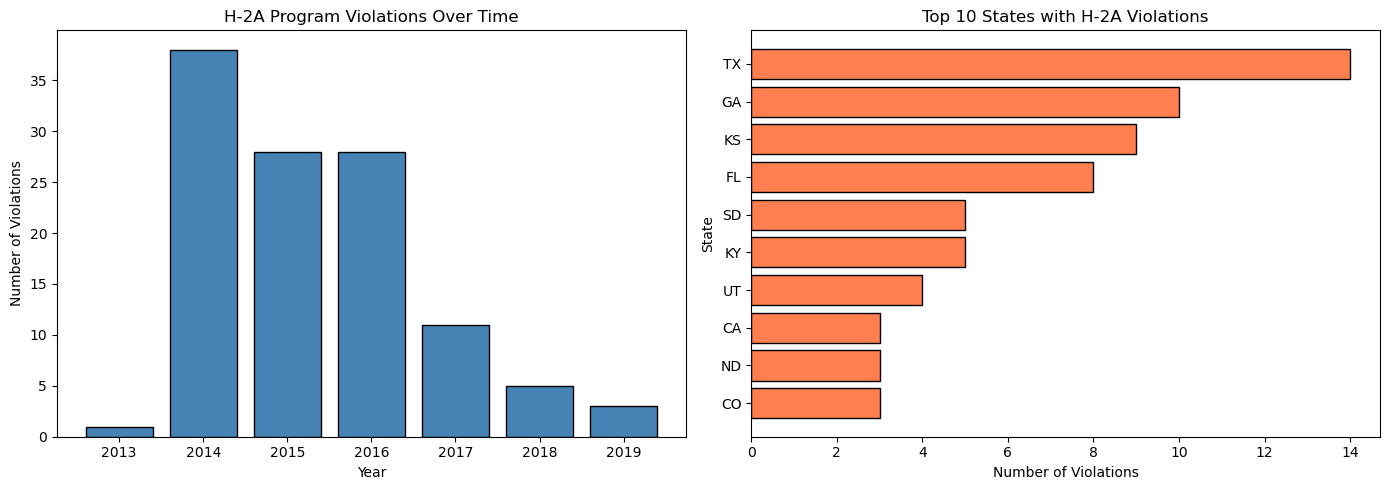


Summary: The data shows 114 total violations across 23 states from 2013 to 2019.


In [56]:
# Convert Start date to datetime and extract year
debar["Start date"] = pd.to_datetime(debar["Start date"], format="mixed")
debar["Year"] = debar["Start date"].dt.year

# Extract state from "City, State" column
debar["State"] = debar["City, State"].str.extract(r',\s*([A-Z]{2})$')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Violations over time (by year)
violations_by_year = debar.groupby("Year").size()
_ = axes[0].bar(violations_by_year.index, violations_by_year.values, color="steelblue", edgecolor="black")
_ = axes[0].set_xlabel("Year")
_ = axes[0].set_ylabel("Number of Violations")
_ = axes[0].set_title("H-2A Program Violations Over Time")
_ = axes[0].set_xticks(violations_by_year.index)

# Top 10 states by number of violations
_ = violations_by_state = debar["State"].value_counts().head(10)
_ = axes[1].barh(violations_by_state.index[::-1], violations_by_state.values[::-1], color="coral", edgecolor="black")
_ = axes[1].set_xlabel("Number of Violations")
_ = axes[1].set_ylabel("State")
_ = axes[1].set_title("Top 10 States with H-2A Violations")
plt.tight_layout()
plt.show()

print(f"\nSummary: The data shows {len(debar)} total violations across {debar['State'].nunique()} states from {debar['Year'].min()} to {debar['Year'].max()}.")

Number of Georgia employers: 74
Unique addresses to geocode: 68
No cache found, starting fresh...
  Full address failed, trying simple address: Lyons, GA 30436
  Full address failed, trying simple address: Tifton, GA 31793
  Full address failed, trying simple address: Wray, GA 31798
  Full address failed, trying simple address: Lyons, GA 30436
  Full address failed, trying simple address: Cobbtown, GA 30420
  Full address failed, trying simple address: Adel, GA 31620
  Full address failed, trying simple address: Parrott, GA 39877
Geocoded 10/68 addresses...
  Full address failed, trying simple address: Leesburg, GA 31763
  Full address failed, trying simple address: Omega, GA 31775
  Full address failed, trying simple address: Lyons, GA 30436
  Full address failed, trying simple address: Lyons, GA 30436
  Full address failed, trying simple address: Cobbtown, GA 30420
  Full address failed, trying simple address: Norman Park, GA 31771
  Full address failed, trying simple address: Pitts,

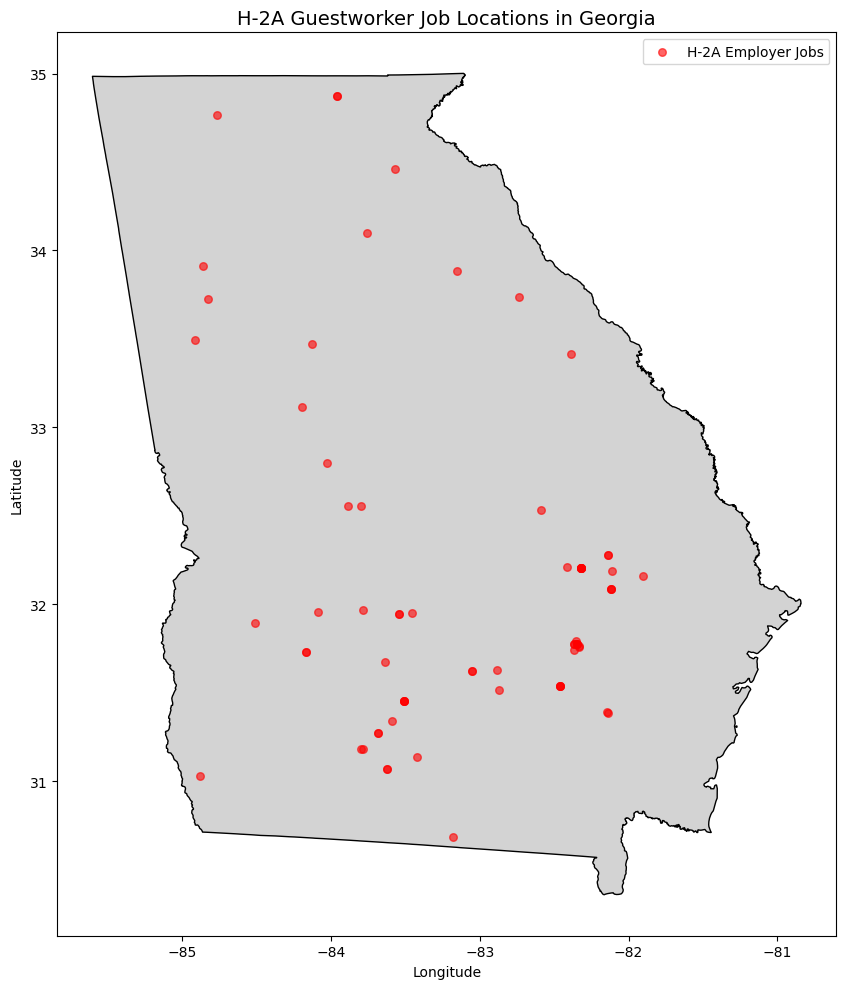


Plotted 74 employer job locations on Georgia map.


In [38]:
%run georgia_jobs_map.py